<a href="https://colab.research.google.com/github/msiplab/AtipWork/blob/master/python/sample_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# スパースモデリング演習

劣決定問題を与える方程式
$$\mathbf{x} = \mathbf{Ds}$$
に基づいてスパース近似を行う。ただし、
- $\mathbf{x}\in\mathbb{R}^N$
- $\mathbf{s}\in\mathbb{R}^{2N}$
- $\mathbf{D}\in\mathbb{R}^{N\times 2N}$

$K\ll N$ 個の非ゼロ係数で近似

$$\tilde{\mathbf{x}}=\mathbf{D}\tilde{\mathbf{s}}$$

を得る。ただし、

- $\tilde{\mathbf{s}}$: $\hat{\mathbf{s}}$のうち絶対値が大きな$K$個の値のみを残して残りを零としたスパース係数ベクトル
- $\hat{\mathbf{s}}$は以下のいずれかの解
 - 標準ノルム解: $\hat{\mathbf{s}} = \arg \min_{\mathbf{s}} \|\mathbf{s}\|_2^2$ s.t. $\mathbf{x}=\mathbf{Ds}$.
 - $\ell_0$疑ノルム解:  $\hat{\mathbf{s}} = \arg \min_{\mathbf{s}} \|\mathbf{s}\|_0$ s.t. $\mathbf{x}=\mathbf{Ds}$.
 - $\ell_1$ノルム解:  $\hat{\mathbf{s}} = \arg \min_{\mathbf{s}} \|\mathbf{s}\|_1$ s.t. $\mathbf{x}=\mathbf{Ds}$.
 - $\ell_1$ノルム正則化:  $\hat{\mathbf{s}} = \arg \min_{\mathbf{s}} \frac{1}{2}\|\mathbf{x}-\mathbf{Ds}\|_2^2+\lambda\|\mathbf{s}\|_1$.

Copyright (C) 2024 Shogo MURAMATSU, All rights reserved

準備

In [51]:
%pip install pandas
%pip install japanize-matplotlib


In [52]:

import numpy as np
from scipy.signal import lfilter
from scipy.linalg import toeplitz
from scipy.optimize import linprog
import matplotlib.pyplot as plt
import japanize_matplotlib
import pandas as pd

# 平均二乗誤差
mse = lambda x,y: np.mean((x-y)**2)

# 日本語フォントの設定
plt.rcParams['font.family'] = 'IPAexGothic'

# 乱数の初期化
np.random.seed(0)

# 係数の数の設定
K = 32

# 数列の生成
N = 128
w = 0.1 * np.random.randn(N)
x = lfilter(1,[1, -0.95],w)

# 合成フィルタ
f0 = np.array([  1., 1. ])/2
f1 = np.array([ -1., 1. ])/2

def convmtx(h, n):
    """Create a convolution matrix equivalent to MATLAB's convmtx."""
    col = np.hstack([h, np.zeros(n - 1)])
    row = np.zeros(n)
    return toeplitz(col, row)

# (巡回)畳み込み行列
P = np.vstack([np.hstack([np.zeros(N-1), 1]), np.eye(N)])
C = np.hstack([np.zeros((N,1)), np.eye(N), np.zeros((N,1))])
d0 = C @ convmtx(f0,N+1) @ P
d1 = C @ convmtx(f1,N+1) @ P

# 辞書Dの構築
D = np.zeros((N,2*N))
D[:,0::2] = d0
D[:,1::2] = d1


## (practice_1) 標準ノルム最小化

標準ノルム最小化
mse = 0.1068


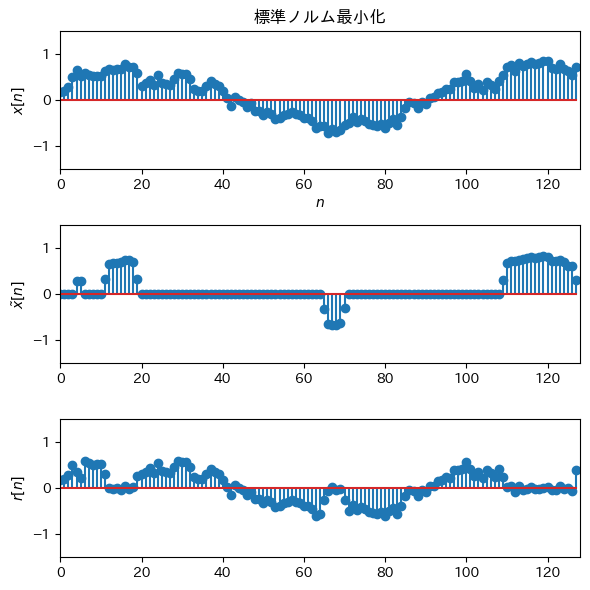

In [53]:
fig1 = plt.figure(figsize=(6, 6))
plt.subplot(3,1,1)
plt.stem(x)
plt.axis([0, N, -1.5, 1.5])
plt.ylabel('$x[n]$')
plt.xlabel('$n$')
plt.title('標準ノルム最小化')

# Moore-Penroseの一般化逆行列による分析処理
y = np.linalg.pinv(D) @ x

# 非線形近似
y = y.ravel()
ix = np.argsort(np.abs(y))[::-1]
y[ix[K:]] = 0

# 評価
# 近似結果
tx = D @ y
plt.subplot(3,1,2)
plt.stem(tx)
plt.axis([0, N, -1.5, 1.5])
plt.ylabel('$\\tilde{x}[n]$')

# 近似誤差
r = x - tx
plt.subplot(3,1,3)
plt.stem(r)
plt.axis([0, N, -1.5, 1.5])
plt.ylabel('$r[n]$')

plt.tight_layout()

print('標準ノルム最小化')
mse_standard_norm = mse(x, tx)
print('mse = %6.4f'%mse_standard_norm)


## (practice_2) 直交マッチング追跡法(OMP)

l0疑ノルム最小化(OMP)
mse = 0.0488


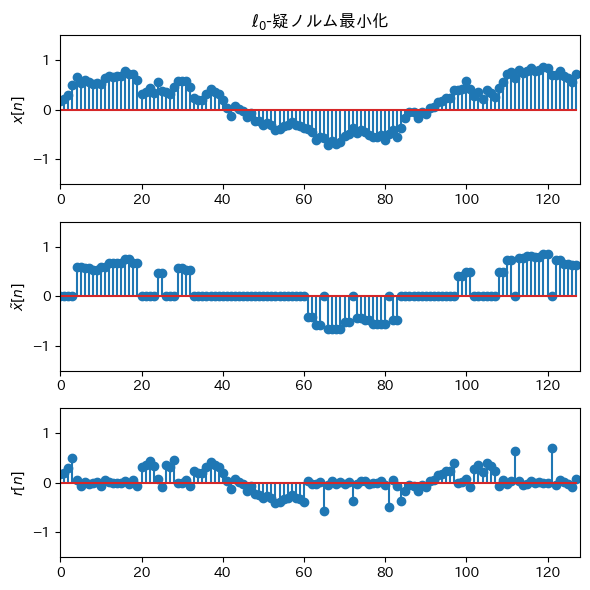

In [54]:
fig2 = plt.figure(figsize=(6, 6))
plt.subplot(3,1,1)
plt.stem(x)
plt.axis([0, N, -1.5, 1.5])
plt.ylabel('$x[n]$')
plt.title('$\ell_0$-疑ノルム最小化')

# 直交マッチング追跡(OMP)法／マッチング追跡(MP)法
isOmp = True
# 初期化
M  = D.shape[1]
e  = np.ones(M)
z  = np.zeros(M)
g  = np.zeros(M)
y  = np.zeros(M)
tx = np.zeros(N)
r  = x - tx
sup = []

for k in range(K):
    # マッチング処理
    for m in range(M):
        d = D[:,m]
        g[m] = d.T @ r
        z[m] = g[m] / np.linalg.norm(d)**2 # (d.T @ d)
        e[m] = np.linalg.norm(r)**2 - g[m] * z[m] # r.T @ r - g[m] * z[m]
    # 最小値探索（追跡）
    mmin = np.argmin(e)
    # サポート更新
    sup = list(set(sup) | {mmin})
    if isOmp:
        Ds = D[:,sup]
        y[sup] = np.linalg.pinv(Ds) @ x
    else:
        y[mmin] += z[mmin]
    # 残差成分
    tx = D @ y
    r = x - tx

# 近似結果
plt.subplot(3,1,2)
hsr = plt.stem(tx)
plt.axis([0, N, -1.5, 1.5])
plt.ylabel('$\\tilde{x}[n]$')
# 近似誤差
plt.subplot(3,1,3)
hse = plt.stem(r)
plt.axis([0, N, -1.5, 1.5])
plt.ylabel('$r[n]$')

plt.tight_layout()

if isOmp:
    print('l0疑ノルム最小化(OMP)')
else:
    print('l0疑疑ノルム最小化(MP)')
mse_l0_norm = mse(x, tx)
print('mse = %6.4f'%mse_l0_norm)


## (practice_3) 基底追跡法(BP)

l1ノルム最小化(BP)
mse = 0.0739


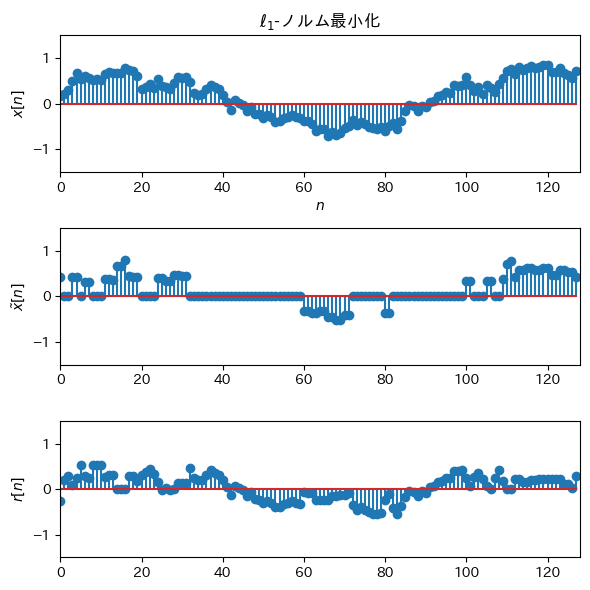

In [55]:
fig3 = plt.figure(figsize=(6, 6))
plt.subplot(3,1,1)
plt.stem(x)
plt.axis([0, N, -1.5, 1.5])
plt.ylabel('$x[n]$')
plt.xlabel('$n$')
plt.title('$\ell_1$-ノルム最小化')

# 線形計画法
M  = D.shape[1]
f  = np.ones(2*M)
lx = np.zeros(2*M)
z  = linprog(f, A_eq=np.hstack([D, -D]), b_eq=x, bounds=[(0, np.inf)] * (2 * M))
y  = z.x[:M] - z.x[M:]

# 非線形近似
y = y.ravel()
ix = np.argsort(np.abs(y))[::-1]
y[ix[K:]] = 0

# 評価
# 近似結果
tx = D @ y
plt.subplot(3,1,2)
plt.stem(tx)
plt.axis([0, N, -1.5, 1.5])
plt.ylabel('$\\tilde{x}[n]$')

# 近似誤差
r = x - tx
plt.subplot(3,1,3)
plt.stem(r)
plt.axis([0, N, -1.5, 1.5])
plt.ylabel('$r[n]$')

plt.tight_layout()

print('l1ノルム最小化(BP)')
mse_l1_norm = mse(x, tx)
print('mse = %6.4f'%mse_l1_norm)


## (practice_4) 基底追跡ノイズ除去(BPDN)（ラッソ回帰）

γ = 1.9980
err = 0.0290
err = 0.0200
err = 0.0216
err = 0.0160
err = 0.0191
err = 0.0146
err = 0.0178
err = 0.0138
err = 0.0169
err = 0.0132
err = 0.0162
err = 0.0128
err = 0.0156
err = 0.0124
err = 0.0151
err = 0.0120
err = 0.0145
err = 0.0116
err = 0.0141
err = 0.0113
err = 0.0137
err = 0.0111
err = 0.0134
err = 0.0108
err = 0.0131
err = 0.0106
err = 0.0128
err = 0.0104
err = 0.0125
err = 0.0102
err = 0.0122
err = 0.0100
err = 0.0119
err = 0.0098
err = 0.0116
err = 0.0095
err = 0.0113
err = 0.0093
err = 0.0111
err = 0.0091
err = 0.0108
err = 0.0089
err = 0.0105
err = 0.0087
err = 0.0103
err = 0.0085
err = 0.0100
err = 0.0083
err = 0.0098
err = 0.0082
err = 0.0096
err = 0.0080
err = 0.0094
err = 0.0078
err = 0.0092
err = 0.0077
err = 0.0090
err = 0.0075
err = 0.0088
err = 0.0074
err = 0.0086
err = 0.0072
err = 0.0084
err = 0.0071
err = 0.0082
err = 0.0070
err = 0.0081
err = 0.0068
err = 0.0079
err = 0.0067
err = 0.0078
err = 0.0066
err = 0.0076
err = 0.0065
err = 0.0075
err = 0.0064
e

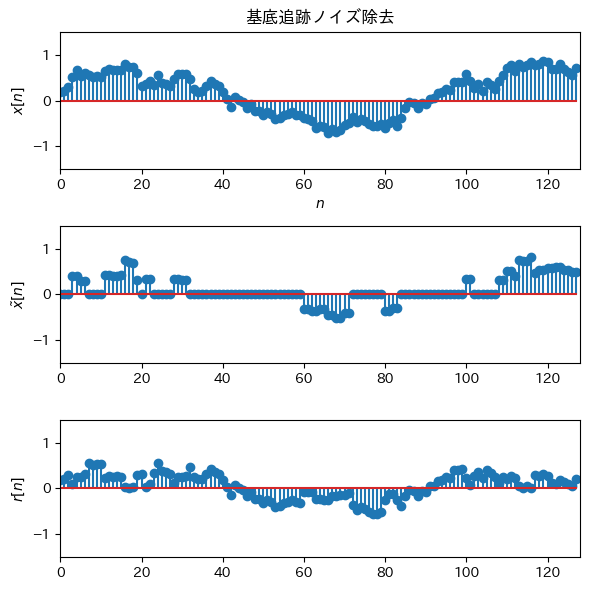

In [56]:
fig4 = plt.figure(figsize=(6, 6))
plt.subplot(3,1,1)
plt.stem(x)
plt.axis([0, N, -1.5, 1.5])
plt.ylabel('$x[n]$')
plt.xlabel('$n$')
plt.title('基底追跡ノイズ除去')

# 正則化パラメータλ，収束条件の設定
lambda_ = 0.0306 # λ
eps    = 1e-4  # ISTA の許容誤差（収束条件）

# ステップサイズ0<γ<=2/βの設定
gamma = (1-1e-3)* (2 / (np.linalg.norm(D,ord=2)**2))
print("γ = %6.4f"%(gamma))

# ソフト閾値関数
soft_threshold = lambda x, th: np.sign(x) * np.maximum(np.abs(x) - th, 0)

# 繰返し縮退／閾値アルゴリズム(ISTA)
tx = x
y = D.T @ tx
err = np.inf
while err > eps:
    ypre = y
    v = D @ ypre
    e = D.T @ (v - x)
    y = soft_threshold(ypre - gamma*e, gamma*lambda_)
    err = np.linalg.norm(y - ypre)**2 / np.linalg.norm(y)**2
    print('err = %6.4f'%err)

# 非線形近似
y = y.ravel()
ix = np.argsort(np.abs(y))[::-1]
y[ix[K:]] = 0

# 評価
# 近似結果
tx = D @ y
plt.subplot(3,1,2)
plt.stem(tx)
plt.axis([0, N, -1.5, 1.5])
plt.ylabel('$\\tilde{x}[n]$')

# 近似誤差
r = x - tx
plt.subplot(3,1,3)
plt.stem(r)
plt.axis([0, N, -1.5, 1.5])
plt.ylabel('$r[n]$')

plt.tight_layout()

print('基底追跡ノイズ除去(BPDN)')
mse_bpdn = mse(x, tx)
print('mse = %6.4f'%mse_bpdn)


## 結果の比較

In [57]:


# mseの比較を表形式で表示
mse_data = {
    'Method': ['標準ノルム最小化', 'l0疑ノルム最小化(OMP)', 'l1ノルム最小化(BP)', '基底追跡ノイズ除去(BPDN)'],
    'MSE': [mse_standard_norm, mse_l0_norm, mse_l1_norm, mse_bpdn]
}

mse_df = pd.DataFrame(mse_data)
mse_df = mse_df.sort_values(by='MSE')
display(mse_df)

,Method,MSE
1,l0疑ノルム最小化(OMP),0.048779
2,l1ノルム最小化(BP),0.073853
3,基底追跡ノイズ除去(BPDN),0.076070
0,標準ノルム最小化,0.106781
